In [7]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import fetch_lfw_people
from collections import Counter
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 910
n_features: 1850
n_classes: 3
Extracting the top 150 eigenfaces from 682 faces
done in 0.073s
done in 0.009s
Fitting the linear classifier to the training set
done in 5.413s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Fitting the rbf classifier to the training set
done in 8.976s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting people's names on the test set (linear kernel)
done in 0.009s
               precision    recall 

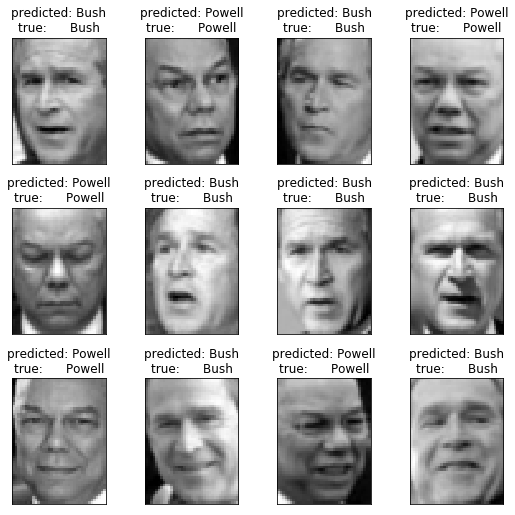

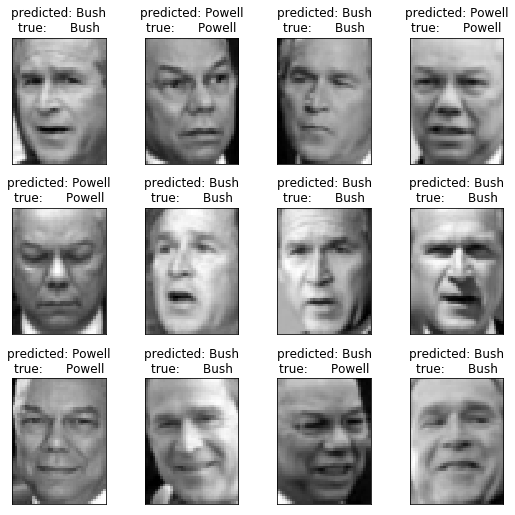

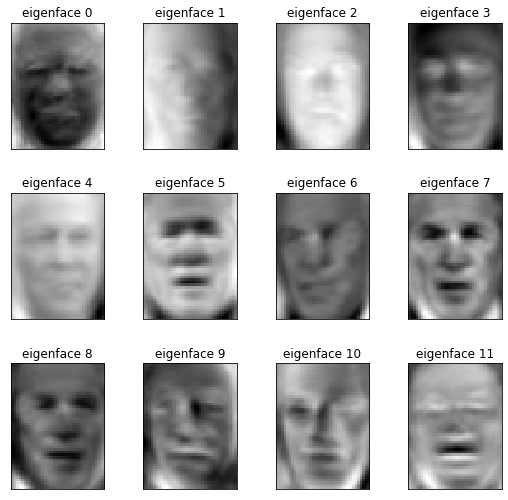

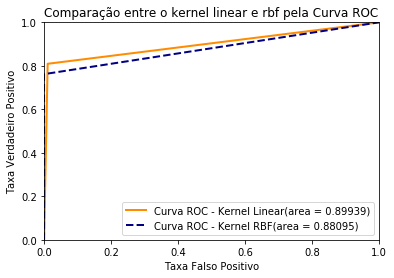

In [14]:
print(__doc__)
from time import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn import metrics


lfw_people = fetch_lfw_people(min_faces_per_person=143, resize=0.4)

n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data

n_features = X.shape[1]


y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

#############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# #############################################################################
# Compute a PCA (eigenfaces) on the 01face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

#print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

# #############################################################################
# Train a SVM classification model

print("Fitting the linear classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf_linear = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param_grid, cv=5)
clf_linear = clf_linear.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_linear.best_estimator_)

print("Fitting the rbf classifier to the training set")
t0 = time()
clf_rbf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
clf_rbf = clf_rbf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_rbf.best_estimator_)

# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set (linear kernel)")
t0 = time()
y_pred_linear = clf_linear.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

linear_confusion_matrix = confusion_matrix(y_test, y_pred_linear, labels=range(n_classes))

print(classification_report(y_test, y_pred_linear, target_names=target_names))
print("Kernel Linear")
print(linear_confusion_matrix)

print("Predicting people's names on the test set (rbf kernel)")
t0 = time()
y_pred_rbf = clf_rbf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

rbf_confusion_matrix = confusion_matrix(y_test, y_pred_rbf, labels=range(n_classes))

print(classification_report(y_test, y_pred_rbf, target_names=target_names))
print("Kernel RBF")
print(rbf_confusion_matrix)


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles_linear = [title(y_pred_linear, y_test, target_names, i)
                            for i in range(y_pred_linear.shape[0])]

plot_gallery(X_test, prediction_titles_linear, h, w)

prediction_titles_rbf = [title(y_pred_rbf, y_test, target_names, i)
                         for i in range(y_pred_rbf.shape[0])]

plot_gallery(X_test, prediction_titles_rbf, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Binarizing the outputs
y_test = y = label_binarize(y_test, classes=[0, 1, 2])
y_pred_linear = y = label_binarize(y_pred_linear, classes=[0, 1, 2])
y_pred_rbf = y = label_binarize(y_pred_rbf, classes=[0, 1, 2])


# Compute ROC curve and ROC area for linear kernel
fpr_linear = dict()
tpr_linear = dict()
roc_auc_linear = dict()

for i in range(n_classes):
    fpr_linear[i], tpr_linear[i], _ = metrics.roc_curve(y_test[:, i], y_pred_linear[:, i])
    roc_auc_linear[i] = metrics.auc(fpr_linear[i], tpr_linear[i])

# Compute micro-average ROC curve and ROC area for linear kernel
fpr_linear["micro"], tpr_linear["micro"], _ = metrics.roc_curve(y_test.ravel(), y_pred_linear.ravel())
roc_auc_linear["micro"] = metrics.auc(fpr_linear["micro"], tpr_linear["micro"])

# Compute ROC curve and ROC area for rbf kernel
fpr_rbf = dict()
tpr_rbf = dict()
roc_auc_rbf = dict()

for i in range(n_classes):
    fpr_rbf[i], tpr_rbf[i], _ = metrics.roc_curve(y_test[:, i], y_pred_rbf[:, i])
    roc_auc_rbf[i] = metrics.auc(fpr_rbf[i], tpr_rbf[i])

# Compute micro-average ROC curve and ROC area for rbf kernel
fpr_rbf["micro"], tpr_rbf["micro"], _ = metrics.roc_curve(y_test.ravel(), y_pred_rbf.ravel())
roc_auc_rbf["micro"] = metrics.auc(fpr_rbf["micro"], tpr_rbf["micro"])

# Plotting and comparing the ROCs curves
plt.figure()
lw = 2
plt.plot(fpr_linear[2], tpr_linear[2], color='darkorange', lw=lw,
         label='Curva ROC - Kernel Linear(area = %0.5f)' % roc_auc_linear[2])
plt.plot(fpr_rbf[2], tpr_rbf[2], color='navy', lw=lw,
         label='Curva ROC - Kernel RBF(area = %0.5f)' % roc_auc_rbf[2], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Verdadeiro Positivo')
plt.title('Comparison between the linear kernel and rbf by ROC Curve')
plt.legend(loc="lower right")
plt.show()